In [452]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig


### Collocation points

In [453]:
sig =7 * 1e2

In [454]:
# Collocation/ Gauss-Chebyshev-Lobatto points
def x(N):
    y = np.cos(np.pi * np.linspace(0, N, N+1)/N)
    return y

# Grid Stretching
def x_strch(N, a):
    x_vals = x(N)
    x_val = x_vals[a]/(x_vals[a] + x_vals)
    return x_val

# tranformation of collocation points to real space
def r_real(N, Lr):
    return ((-0.5 * x(N) + 0.5) * Lr)/sig

def z_real(M,  Lz):
    return ((0.5 * x(M) - 0.5) * Lz)/sig

In [455]:
# def plot_chebyshev_nodes(N):
#     # Compute the Chebyshev nodes
#     y = x(N)
    
#     # Create a plot
#     plt.figure(figsize=(10, 2))
#     plt.plot(y, np.zeros_like(y), 'rs')  # Plot nodes as blue dots
#     plt.title(f'Chebyshev Nodes for N={N}')
#     plt.xlabel('x')
#     plt.yticks([])  # Hide y-axis ticks
#     plt.grid(True)
#     plt.axhline(0, color='black',linewidth=0.5)  # Add a horizontal line at y=0
    
#     # Annotate nodes
#     for i, txt in enumerate(np.round(y, 3)):
#         plt.annotate(txt, (y[i], 0), textcoords="offset points", xytext=(0,10), ha='center')

#     # Show the plot
#     plt.show()

# # Example usage
# plot_chebyshev_nodes(10)


### Differentiation matrix

In [456]:
# Chebyshev differentiation matrix
def Cheb_der(N,y):
    n = len(y)
    D = np.zeros((n,n))
    c = np.ones_like(y)
    c[0] = 2
    c[-1] = 2
    for k in range(n):
        for j in range(n):
            if k!=j:
                D[k,j] = (c[k] * (-1)**(k+j))/(c[j] * (y[k]-y[j]))
            # else:
            #     if k==0 and j==0:
            #         D[k,j] = (2 * N**2 + 1)/6
            #     elif k==N and j==N:
            #         D[k,j] = -D[0,0]
            #     else:    
            #         D[k,j] = -(y[k])/(2 * (1 - y[k]**2))
            else:
                D[k,j] = -(y[k])/(2 * (1 - y[k]**2))
    D[0,0] = (2 * N**2 + 1)/6
    D[N,N] = -D[0,0]
    return D

def diff_mat(N, M, Lr, Lz):
    r2 = x(N)
    z2 = x(M)
    jac_r = 1/(-0.5 * Lr)
    jac_z = 1/(0.5 * Lz)
    dr = Cheb_der(N, r2)
    dz = Cheb_der(M, z2)
    nr = len(x(N))
    nz = len(x(M))
    Ir = np.identity(nr)
    Iz = np.identity(nz)
    Dr = np.kron(Iz, jac_r * dr * sig) 
    Dz = np.kron(jac_z * dz * sig, Ir)
    D2r = np.kron(Iz, jac_r**2 * (dr@dr) * sig**2)
    D2z = np.kron(jac_z**2 * (dz@dz)* sig**2, Ir) 
    Drdz = Dr@Dz
    Dzdr = Dz@Dr
    return Dr, Dz, D2r, D2z, Drdz, Dzdr, dz*sig*jac_z         


# def diff_mat(N, M, Lr, Lz):
#     r2 = x(N)
#     z2 = x(M)
#     jac_r = 1/(0.5 * Lr)
#     jac_z = 1/(-0.5 * Lz)
#     dr = Cheb_der(N, r2)
#     dz = Cheb_der(M, z2)
#     nr = len(x(N))
#     nz = len(x(M))
#     Ir = np.identity(nr)
#     Iz = np.identity(nz)
#     Dr = np.kron(jac_r * dr * sig, Iz) 
#     Dz = np.kron(Ir, jac_z * dz * sig)
#     D2r = np.kron(jac_r**2 * (dr@dr) * sig**2, Iz)
#     D2z = np.kron(Ir, jac_z**2 * (dz@dz)* sig**2) 
#     Drdz = Dr@Dz
#     Dzdr = Dz@Dr
#     return Dr, Dz, D2r, D2z, Drdz, Dzdr, dz*sig*jac_z   

In [457]:
# nonzero_indices = np.nonzero(diff_mat(10, 10, 1, 1)[3]+diff_mat(10, 10, 1, 1)[2])  # Get indices of non-zero elements

# # Scatter plot of non-zero elements
# plt.scatter(nonzero_indices[1], nonzero_indices[0], marker='*', color='blue', s=0.0001)
# plt.gca().invert_yaxis()  # Invert y-axis to match matrix indexing
# plt.title('Non-zero Elements of the Matrix')
# plt.xlabel('Column Index')
# plt.ylabel('Row Index')
# plt.grid(True)
# plt.show()

### Mean Flow

In [458]:
def mean_flow(r, z):
    a1 , a2 = 0.7, -0.9
    f = 7.292 * 1e-5
    g = -10
    # sig = 3 * 1e1

    ###########################

    rho_per = a1 * np.exp(z*sig) * np.exp(-r**2)
    rho_r = np.exp(-r**2)
    rho_b = 1
    rho_z = a2 * z * sig
    rho_bar = (rho_per + rho_b + rho_z)/rho_b

    ###########################

    # pres_0 = (a1 * z**2 + a2 * z)
    # pres_b = rho_b * z 
    # pres_bar = g * pres_0 * rho_r + g * pres_b

    pres_0 = a1 * np.exp(z) * rho_r
    pres_z = (rho_b * z + a2 * z**2 /2) 
    # pres_const = -rho_b * Lz + a2 * Lz**2/2
    pres_const = 0
    # pres_bar = (pres_0 * rho_r + pres_z + pres_const)*g/(a1*np.exp(-1) *(g))
    # pres_bar = -(pres_0 * rho_r + pres_z + pres_const)/(a1*np.exp(-1))

    pres_bar = -(np.exp(z*sig) + 1) * a1 * rho_r * g + rho_b * z*sig * g + a2 * z**2 * sig**2 * g/2 - 2 * a1 * g


    ###########################
    
    # # b = f * r
    # b = 1/Ro
    # c = 2 * r**2 * np.exp(z+1) * np.exp(-r**2)/((rho_per+rho_z)/rho_b+ 1)
    # c = 2 * r**2/sig**2 * (pres_0 * g* rho_r)/ rho_bar
    # # c = (2 * r**2/sig**2 * pres_0 * g)/rho_bar
    # # u_bar = (-b + np.sqrt(b**2 - 4 * c))/2
    # u_scale = np.sqrt(-a1 * np.exp(-1) * g/rho_b)
    # u_bar =  (-b + np.sqrt(b**2 - 4 * c))/2

    b = f * r
    c = (np.exp(z*sig)+1) * a1 * g * (2 * r**2) * rho_r /rho_bar
    u_bar =  (-b + np.sqrt(b**2 - 4 * c))/2
    u_max = u_bar.max()
    u_nd = u_bar/u_max
    pres_nd = pres_bar/(u_max**2 * rho_b)

    return rho_bar, pres_nd, u_nd, rho_per, u_max

### To appropriate sizes

In [459]:
def coefficient_matrix(N, M, Lr, Lz, r, z):
    r1, z1 = r_real(N, Lr), z_real(M,  Lz)
    nr, nz = len(r1), len(z1)

    r_grids = np.diag(np.tile(r1, nz))
    z_grids = np.diag(np.repeat(z1, nr))

    rho_mean = mean_flow(r, z)[0].flatten()
    u_mean = mean_flow(r, z)[2].flatten()

    rho = np.diag(rho_mean)
    u_theta = np.diag(u_mean)

    D = diff_mat(N, M, Lr, Lz)
    dru = np.diag(np.dot(D[0], u_mean))
    d2ru = np.diag(np.dot(D[2], u_mean))
    dzu = np.diag(np.dot(D[1], u_mean))
    d2zu = np.diag(np.dot(D[3], u_mean))
    drdzu = np.diag(np.dot(D[4], u_mean))

    drrho = np.diag(np.dot(D[0], rho_mean))
    d2rrho = np.diag(np.dot(D[2], rho_mean))
    dzrho = np.diag(np.dot(D[1], rho_mean))
    d2zrho = np.diag(np.dot(D[3], rho_mean))
    drdzrho = np.diag(np.dot(D[4], rho_mean))

    return r_grids, z_grids, rho, u_theta, dru, d2ru, dzu, d2zu, drdzu, drrho, d2rrho, dzrho, d2zrho, drdzrho

In [460]:
def A(N, M, Lr, Lz, r, z, Pe, Ro, Fr, n):
    D = diff_mat(N, M, Lr, Lz)
    Dr = D[0]
    Dz = D[1]
    Dr2 = D[2]
    Dz2 = D[3]
    DrDz = D[4]
    DzDr = D[5]


    G = coefficient_matrix(N, M, Lr, Lz, r, z)
    R = G[0]
    Rho = G[2]
    U = G[3]
    Dru = G[4]
    Dzu = G[6]
    Drrho = G[9]
    Dzrho = G[11]

    I = np.identity((N+1)*(M+1))
    T = n * I
    nr = N+1
    nz = M+1

#     A11 = (-n**2 * R@Rho@Dzu - n**2 * R@Rho@U@Dz - 1j * n * R@Rho@Dzu
#            -1j * n * R@Rho@U@Dz - n**2 * U@Rho - n**2 * R@U@Dzrho
#            + R@Rho@Dzu + R@Rho@U@Dz + 2 * R@U@Dzrho + 1/Ro * R@R@Rho@Dz
#            + 1/Ro * R@R@Dzrho + R@R@Rho@Dzu@Dr + R@R@Rho@U@DzDr + 2 * R@R@Dzrho@U@Dr
#            + 1/Ro * R@R@R@Rho@DzDr + 1/Ro * R@R@R@Dzrho@Dr)

    A11 = (-T**2 @ R@Rho@Dzu - T**2 @ R@Rho@U@Dz - 1j * T @ R@Rho@Dzu
              -1j * T @ R@Rho@U@Dz - T**2 @ U@Rho - T**2 @ R@U@Dzrho
              + R@Rho@Dzu + R@Rho@U@Dz + 2 * R@U@Dzrho + 1/Ro * R@R@Rho@Dz
              + 1/Ro * R@R@Dzrho + R@R@Rho@Dzu@Dr + R@R@Rho@U@DzDr + 2 * R@R@Dzrho@U@Dr
              + 1/Ro * R@R@R@Rho@DzDr + 1/Ro * R@R@R@Dzrho@Dr)
    
#     A12 = (n**2 * R@Rho@Dru + n**2 * R@Rho@U@Dr + n**2 * R@Drrho@U + R@R@Rho@Dzu@Dz
#             + R@R@Rho@U@Dz2 + 2 * R@R@Dzrho@U@Dz + 1/Ro * R@R@R@Rho@Dz2 + 1/Ro * R@R@R@Dzrho@Dz)
    A12 = (T**2 @ R@Rho@Dru + T**2 @ R@Rho@U@Dr + T**2 @ R@Drrho@U + R@R@Rho@Dzu@Dz
            + R@R@Rho@U@Dz2 + 2 * R@R@Dzrho@U@Dz + 1/Ro * R@R@R@Rho@Dz2 + 1/Ro * R@R@R@Dzrho@Dz)
    
#     A13 = (-2j * n * R@U@Dzu - 1j * n * 1/Ro * R@R@Dzu - 1j * n * R@U@U@Dz 
#            - 1j * n * 1/Ro * R@R@U@Dz - 1j * n * 1/Fr**2 * R@R@Dr)
    A13 = (-2j * T @ R@U@Dzu - 1j * 1/Ro * T @  R@R@Dzu - 1j * T @ R@U@U@Dz 
           - 1j * 1/Ro * T @R@R@U@Dz + 1j * 1/Fr**2 * T @  R@R@Dr)

    # ###############################################################

    # A21 = (1j*n * ((1j*n-1) * (Rho@Dzu + Rho@U@Dz)+ 1j*n*Dzrho@U)
    #     - 2*Rho@Dzu - 2*Rho@U@Dz - 2*Dzrho@U + 2*R@Rho@Dzu@Dr
    #     + 2*R@Dzrho@U@Dr + 2*R@Rho@U@DrDz 
    #     -1/Ro *(R@Rho@Dz - R@R@Rho@DzDr))

    A21 = (-1j * n * R@Rho@Dzu - 1j * n * R@Rho@U@Dz - 1j * n * R@R@Rho@DzDr@U - 1j * n * R@R@Rho@Dru@Dz
           -1j * n * R@R@Dzrho@Dru - 1j * n * R@Dzrho@U - 1j * n * R@R@Dzrho/Ro - 1j * n * R@R@Rho@Dz/Ro
           +1j * n * R@Rho@Dzu + 1j * n * R@Rho@U@Dz + 1j * n * R@Dzrho@U + 1j * n * R@R@Rho@Dzu@Dr
           + 1j * n * R@R@Rho@U@DzDr + 1j * n * R@R@Dzrho@U@Dr)
    

    # A22 = (1j*n * (-1j*n*Rho@Dru - 1j*n*U@Rho@Dr -1j*n*Dzrho@U)
    #     -2*R@Rho@Dzu@Dz - 2*R@Dzrho@U@Dz - 2*R@Rho@U@Dz2 
    #     -1/Ro * R@R@Rho@Dz2)
    A22 = (-1j * n**3 * Rho@U - 1j * n * R@R@Rho@Dz2@U - 1j * n * R@R@Rho@Dzu@Dz
           -1j * n * R@R@Dzrho@Dzu + 1j * n * R@R@Rho@Dzu@Dz + 1j * n * R@R@Rho@U@Dz2 + 1j * n * R@R@Dzrho@U@Dz)


    # A23 = (1j*n*(-2*U@Dzu - U@U@Dz - 1/Ro *(R@Dzu + U@Dz) - 1/Fr**2 *R@Dr))
    A23 = (n * n * R/Fr**2)

    # #####################################################################

    A31 = R@R@Drrho

    A32 = R@R@Dzrho

    A33 = 1j * n * R@U - (1/Pe) * R@R@Dr2 - (1/Pe) * R@Dr + (1/Pe) * n**2 * I - (1/Pe) * R@R@Dz2


    # A33 = (1j * n * R @ U
    #         + R@R @ Dr2 * (-1/D)
    #         + R @ Dr * (-1/D)
    #         - n**2/D * I - R@R@Dz2/D)
    
    #####################################################################################
    #Boundary conditon

    for i in range(nz):
       #  r = R
       #  Dirichlet condition at r = R
       A11[(i+1)*N + 1, :] = I[(i+1)*N + i, :]
       A12[(i+1)*N + 1, :] = 0
       A13[(i+1)*N + 1, :] = 0

       A21[(i+1)*N + 1, :] = 0
       A22[(i+1)*N + 1, :] = I[(i+1)*N + i, :]
       A23[(i+1)*N + 1, :] = 0

       A31[(i+1)*N + 1, :] = 0
       A32[(i+1)*N + 1, :] = 0
       A33[(i+1)*N + 1, :] = I[(i+1)*N + i, :]

       # # R = 0
       # # Neumann condition
       # A11[i*N + i, :] = Dr[i*N + i, :]
       # A12[i*N + i, :] = 0
       # A13[i*N + i, :] = 0

       # A21[i*N + i, :] = 0
       # A22[i*N + i, :] = Dr[i*N + i, :]
       # A23[i*N + i, :] = 0

       A31[i*N + i, :] = 0
       A32[i*N + i, :] = 0
       A33[i*N + i, :] = Dr[i*N + i, :]

    # z = -h
    # Dirichlet condition
    A11[M*N + M:, :] = I[M*N + M:, :]
    A12[M*N + M:, :] = 0
    A13[M*N + M:, :] = 0

    A21[M*N + M:, :] = 0
    A22[M*N + M:, :] = I[M*N + M:, :]
    A23[M*N + M:, :] = 0

    A31[M*N + M:, :] = 0
    A32[M*N + M:, :] = 0
    A33[M*N + M:, :] = I[M*N + M:, :]

    # z = 0
    # Neumann condition
#     A11[:N+1,:] = Dz[:N+1,:]
#     A12[:N+1,:] = 0
#     A13[:N+1,:] = 0

    A21[:N+1,:] = 0
    A22[:N+1,:] = Dz[:N+1,:]
    A23[:N+1,:] = 0

    A31[:N+1,:] = 0
    A32[:N+1,:] = 0
    A33[:N+1,:] = Dz[:N+1,:]

    Amatrix = np.block([[A11,A12,A13],[A21,A22,A23],[A31,A32,A33]])

    return Amatrix

In [461]:
def B(N, M, Lr, Lz,r, z, n): 
    D = diff_mat(N, M, Lr, Lz)
    Dr = D[0]
    Dz = D[1]
    Dr2 = D[2]
    Dz2 = D[3]
    DzDr = D[5]

    
    G = coefficient_matrix(N, M, Lr, Lz, r, z)
    R = G[0]
    Rho = G[2]
    Drrho = G[9]
    Dzrho = G[11]

    I = np.identity((N+1)*(M+1))
    nr = N+1
    nz = M+1


    # Non-dimensionalized equation
    # B11 = (-n**2*R@Rho - 1j*n*R@R@Dzrho - R@R@R@Rho@Dr2
    #         -R@R@Rho@Dr + R@Rho)
    B11 = 1j * (1j * n * R@R@Rho@Dz + 1j * n* R@R@Dzrho)
    # B12 = -1j*n*(R@R@Drrho) + R@R@Rho@Dz + R@R@R@Rho@DzDr + R@R@Rho@Dz
    B12 = 1j * (-1j * n * R@R@Rho@Dr - 1j * n* R@R@Drrho)
    B13 = I * 0
    # ############################################################
    # B21 = 1j*n*(R@Rho@Dz + R@Dzrho)
    # B22 = -1j*n*(R@Rho@Dr + R@Dzrho)
    # B23 = I*0

    B21 = 1j * (R@R@Rho@Dz + R@R@Dzrho + R@R@R@Rho@DzDr + R@R@R@Dzrho@Dr)
    B22 = 1j * (-n**2 * R@Rho + R@R@R@Rho@Dz2 + R@R@R@Dzrho@Dz)
    B23 = I * 0
    #  ###########################################################3
    B31 = I * 0
    B32 = I * 0
    B33 = 1j * R@R
   #  B33 = I * 0

    #####################################################################################
    #Boundary conditon

    for i in range(nz):
       #  r = R
       #  Dirichlet condition at r = R
       B11[(i+1)*N + 1, :] = 0
       B12[(i+1)*N + 1, :] = 0
       B13[(i+1)*N + 1, :] = 0

       B21[(i+1)*N + 1, :] = 0
       B22[(i+1)*N + 1, :] = 0
       B23[(i+1)*N + 1, :] = 0

       B31[(i+1)*N + 1, :] = 0
       B32[(i+1)*N + 1, :] = 0
       B33[(i+1)*N + 1, :] = 0

       # R = 0
       # Neumann condition
      #  B11[i*N + i, :] = 0
      #  B12[i*N + i, :] = 0
      #  B13[i*N + i, :] = 0

      #  B21[i*N + i, :] = 0
      #  B22[i*N + i, :] = 0
      #  B23[i*N + i, :] = 0

       B31[i*N + i, :] = 0
       B32[i*N + i, :] = 0
       B33[i*N + i, :] = 0

    # z = -h
    # Dirichlet condition
    B11[M*N + M:, :] = 0
    B12[M*N + M:, :] = 0
    B13[M*N + M:, :] = 0

    B21[M*N + M:, :] = 0
    B22[M*N + M:, :] = 0
    B23[M*N + M:, :] = 0

    B31[M*N + M:, :] = 0
    B32[M*N + M:, :] = 0
    B33[M*N + M:, :] = 0

    # z = 0
    # Neumann condition
   #  B11[:N+1,:] = 0
   #  B12[:N+1,:] = 0
   #  B13[:N+1,:] = 0

    B21[:N+1,:] = 0
    B22[:N+1,:] = 0
    B23[:N+1,:] = 0

    B31[:N+1,:] = 0
    B32[:N+1,:] = 0
    B33[:N+1,:] = 0
   

    Bmatrix = np.block([[B11,B12,B13],[B21,B22,B23],[B31,B32,B33]])

    return Bmatrix

In [462]:
def calculate_eigenvalues_and_vectors(N, M, Lr, Lz, r, z, Pe, Ro, Fr, n):
    A_mat = A(N, M, Lr, Lz, r, z, Pe, Ro, Fr, n)
    B_mat = B(N, M, Lr, Lz, r, z, n)
    
    omega, X = eig(A_mat, B_mat)
    
    max_imag_value = None
    index = None
    for i in range(len(omega)):
        current_real_part = np.real(omega[i])
        current_imag_part = np.imag(omega[i])

        # Check if real part is less than 100 and real part is finite
        if abs(current_real_part) < 100 and np.isfinite(current_real_part):
            if abs(current_imag_part) < 100 and np.isfinite(current_imag_part):
        # if np.isfinite(current_real_part)and np.isfinite(current_imag_part):
                if max_imag_value is None or current_imag_part > np.imag(max_imag_value):
                    max_imag_value = omega[i]
                    index = i

        # if np.isfinite(current_imag_part) and np.isfinite(current_real_part):
        #     if max_imag_value is None or current_imag_part > np.imag(max_imag_value):
        #         max_imag_value = omega[i]
        #         index = i
    # max_real_value = None
    # index = None
    # for i in range(len(omega)):
    #     current_real_part = np.real(omega[i])
    #     current_imag_part = np.imag(omega[i])

    #     # # Check if real part is less than 100 and real part is finite
    #     # if abs(current_imag_part) < 100 and np.isfinite(current_imag_part):
    #     #     if abs(current_real_part) < 100 and np.isfinite(current_real_part):
    #     #         if max_real_value is None or current_real_part > np.real(max_real_value):
    #     #             max_real_value = omega[i]
    #     #             index = i
    #     if np.isfinite(current_real_part)and np.isfinite(current_imag_part):
    #         if max_real_value is None or current_real_part > np.real(max_real_value):
    #             max_real_value = omega[i]
    #             index = i


    eigen_vector = X[:, index]
    norm_index = np.argmax(np.abs(eigen_vector))  # Find index of maximum absolute value
    norm_eigenvector = eigen_vector / eigen_vector[norm_index]
    ur1, uz1, rho1 = np.split(norm_eigenvector, 3)
    # ur1, uz1, rho1 = np.split(eigen_vector, 3)

    ur = ur1.reshape(M+1, N+1)
    uz = uz1.reshape(M+1, N+1)
    rho = rho1.reshape(M+1, N+1)
    minimum_value = min(np.real(norm_eigenvector))
    maximum_value = max(np.real(norm_eigenvector))

    return max_imag_value, ur, uz, rho, minimum_value, maximum_value, omega


In [463]:
N = 22
M = 22
Lr = 2 * 1e3
Lz = 0.5 * 1e1
Pe = 1e-5
Ro = 49.369  
Fr = 3e-2
r, z = r_real(N, Lr), z_real(M,  Lz)
r, z = np.meshgrid(r, z)
eigvalvec = calculate_eigenvalues_and_vectors(N, M, Lr, Lz, r, z, Pe, Ro, Fr, 6)
velocity = eigvalvec[0]
# # print(velocity.shape)
print(velocity)
# print((diff_mat(N, M, Lr, Lz)[1]@np.transpose(velocity.flatten())).reshape(M+1, N+1))
# np.set_printoptions(threshold=np.inf)
# print(A(N, M, Lr, Lz, r, z, Pe, Ro, Fr, 0))

/tmp/ipykernel_153141/3113353165.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  D[k,j] = -(y[k])/(2 * (1 - y[k]**2))


(7.3770654319333815+60.69637778344223j)


In [464]:
# plt.plot(np.real(eigvalvec[6]), np.imag(eigvalvec[6]), "o")
# plt.ylim([-10, 10])
# plt.xlim([-10, 10])

### Plotting

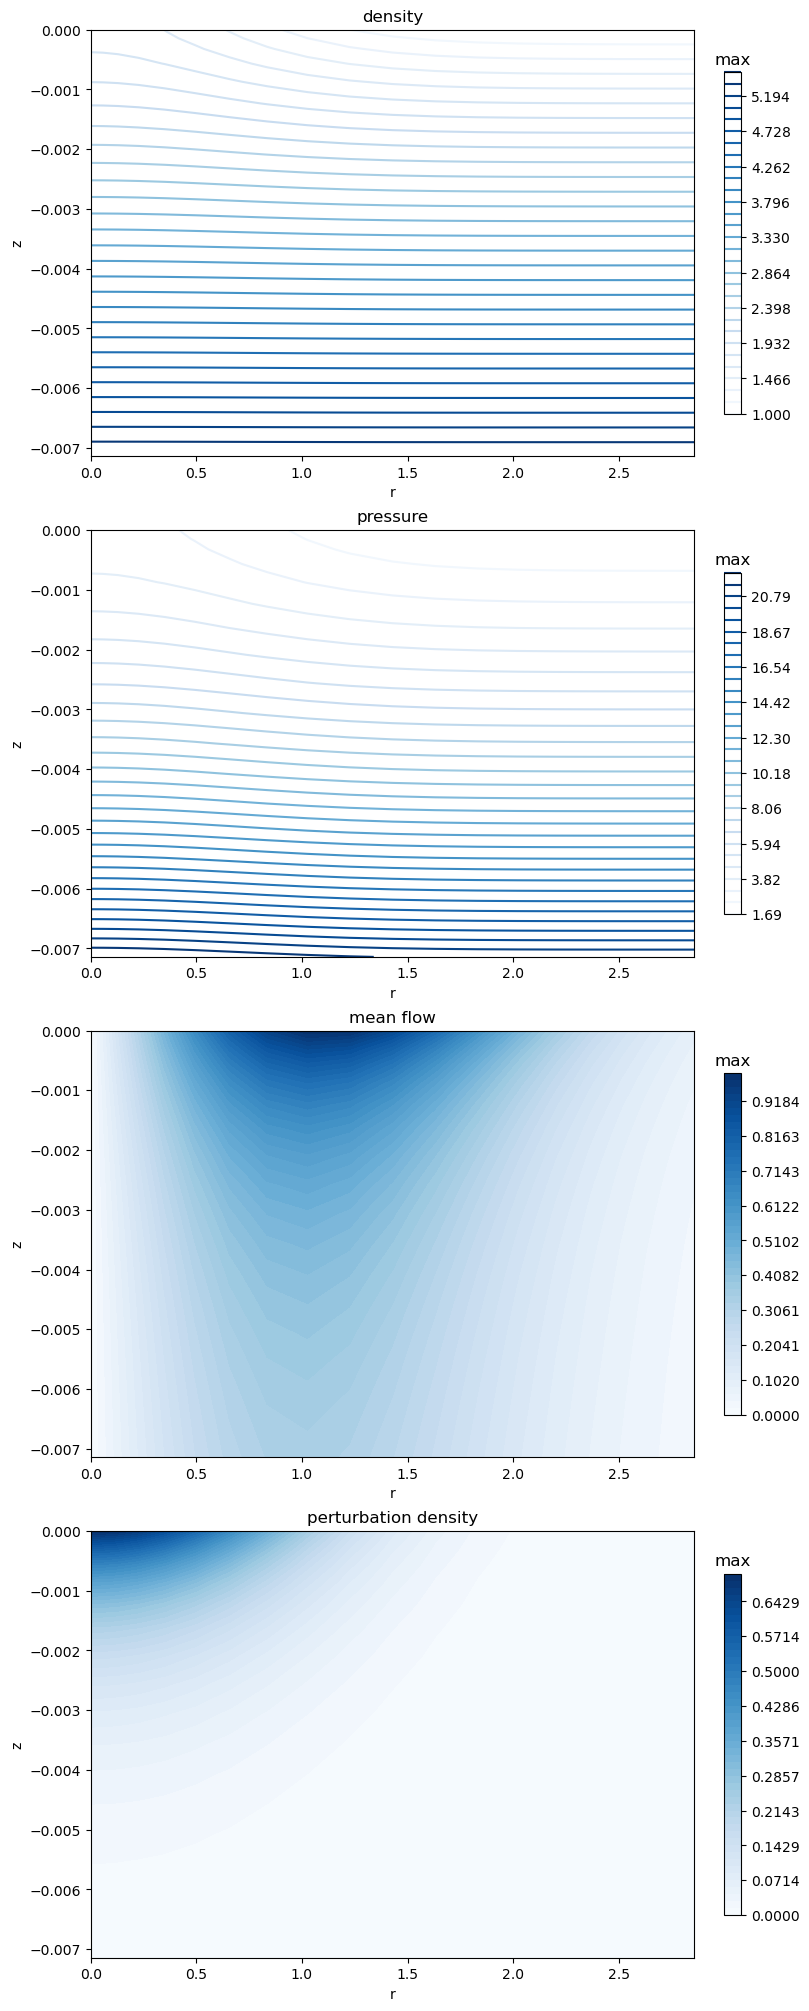

In [465]:
# # Mean flow:
u = mean_flow(r, z)[2]
rho = mean_flow(r, z)[0]
p = mean_flow(r, z)[1]
rho_p = mean_flow(r, z)[3]

u_max = np.max(u)
u_index = np.where(u==u_max)
levels = np.linspace(rho.min(), rho.max(), 30)
levels1 = np.linspace(p.min(), p.max(), 30)
levels2 = np.linspace(u.min(), u.max())
levels3 = np.linspace(rho_p.min(), rho_p.max())

fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=((8, 20))) 
im1=axs[0].contour(r, z, rho, levels=levels, cmap='Blues')
im2=axs[1].contour(r, z, p, levels=levels1, cmap='Blues')
if u.min() < 0 and u.max() <= 0:
    im3=axs[2].contourf(r, z, u, levels=levels2, cmap='viridis')
else:
    im3=axs[2].contourf(r, z, u, levels=levels2, cmap='Blues')
im4=axs[3].contourf(r, z, rho_p, levels=levels3, cmap='Blues')
# axs[3].set_xlim([0, 4])
# axs[3].set_ylim([-0.2, 0])

# axs[2].set_xlim([0, 4])
# axs[2].set_ylim([-0.2, 0])

cbar = fig.colorbar(im1, ax=axs[0], shrink=0.8)
# cbar.set_ticks([])
cbar.ax.set_title('max')


cbar = fig.colorbar(im2, ax=axs[1], shrink=0.8)
# cbar.set_ticks([])
cbar.ax.set_title('max')


cbar = fig.colorbar(im3, ax=axs[2], shrink=0.8)
# cbar.set_ticks([])
cbar.ax.set_title('max')

cbar = fig.colorbar(im4, ax=axs[3], shrink=0.8)
# cbar.set_ticks([])
cbar.ax.set_title('max')

# titles
axs[0].set_title('density')
axs[0].set_xlabel('r')
axs[0].set_ylabel('z')

axs[1].set_title('pressure')
axs[1].set_xlabel('r')
axs[1].set_ylabel('z')

axs[2].set_title('mean flow')
axs[2].set_xlabel('r')
axs[2].set_ylabel('z')

axs[3].set_title('perturbation density')
axs[3].set_xlabel('r')
axs[3].set_ylabel('z')

plt.show()


In [466]:
print( mean_flow(r, z)[4])

2.8752687812264717


In [467]:

# fig, axs = plt.subplots(4, 1, constrained_layout=True, figsize=((8, 20))) 
# im1=axs[0].contour(r, z, rho, levels=levels, cmap='Blues')
# im2=axs[1].contour(r, z, p, levels=levels1, cmap='Blues')
# if u.min() < 0 and u.max() <= 0:
#     im3=axs[2].contour(r, z, u, levels=levels2, cmap='viridis')
# else:
#     im3=axs[2].contour(r, z, u, levels=levels2, cmap='RdBu')
# im4=axs[3].contour(r, z, rho_p, levels=levels3, cmap='Blues')


# cbar = fig.colorbar(im1, ax=axs[0], shrink=0.8)
# # cbar.set_ticks([])
# cbar.ax.set_title('max')


# cbar = fig.colorbar(im2, ax=axs[1], shrink=0.8)
# # cbar.set_ticks([])
# cbar.ax.set_title('max')


# cbar = fig.colorbar(im3, ax=axs[2], shrink=0.8)
# # cbar.set_ticks([])
# cbar.ax.set_title('max')

# cbar = fig.colorbar(im4, ax=axs[3], shrink=0.8)
# # cbar.set_ticks([])
# cbar.ax.set_title('max')

# # titles
# axs[0].set_title('density')
# axs[0].set_xlabel('r')
# axs[0].set_ylabel('z')

# axs[1].set_title('pressure')
# axs[1].set_xlabel('r')
# axs[1].set_ylabel('z')

# axs[2].set_title('mean flow')
# axs[2].set_xlabel('r')
# axs[2].set_ylabel('z')

# axs[3].set_title('perturbation density')
# axs[3].set_xlabel('r')
# axs[3].set_ylabel('z')

# plt.show()

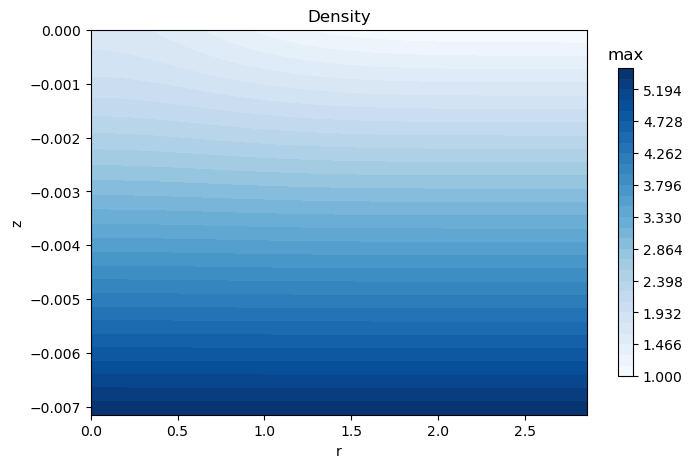

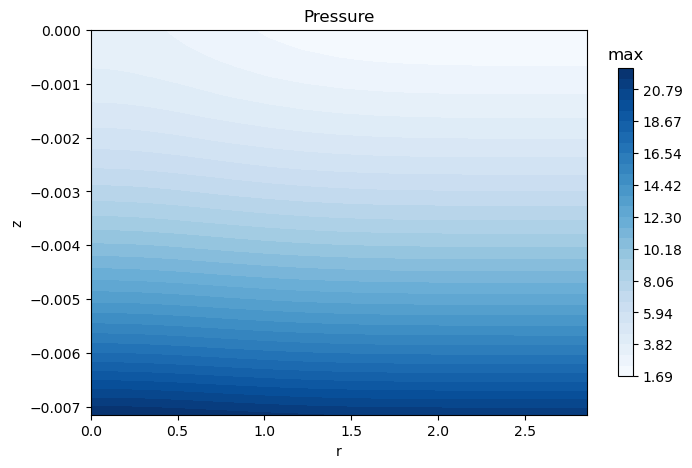

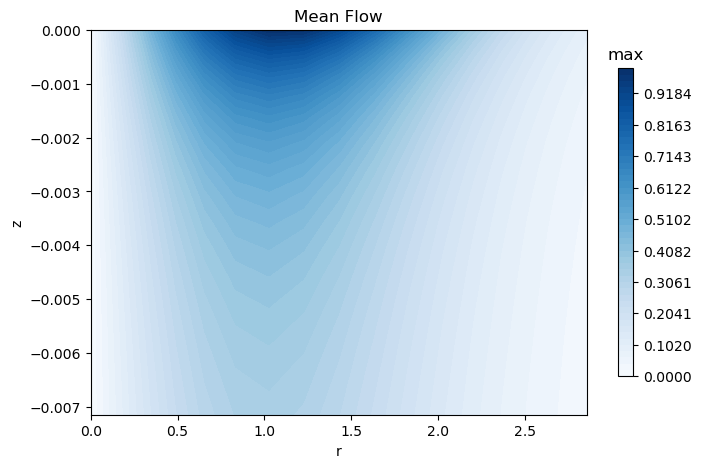

Text(0, 0.5, 'z')

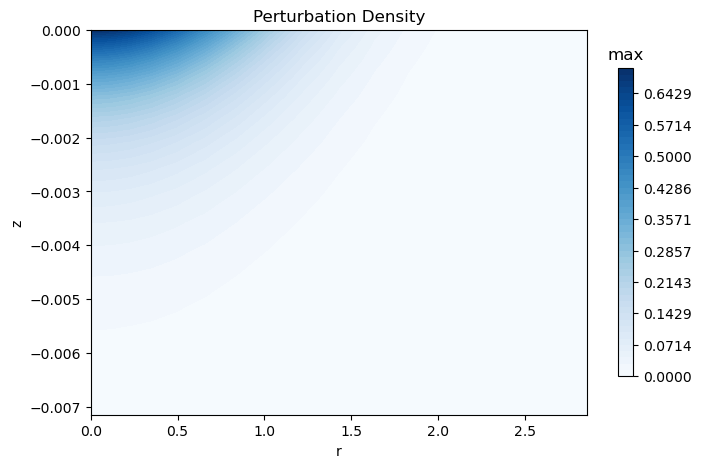

In [468]:
# Plot density
fig1, ax1 = plt.subplots(figsize=(8, 5))
im1 = ax1.contourf(r, z, rho, levels=levels, cmap='Blues')
cbar1 = fig1.colorbar(im1, ax=ax1, shrink=0.8)
cbar1.ax.set_title('max')
ax1.set_title('Density')
ax1.set_xlabel('r')
ax1.set_ylabel('z')
plt.show()

# Plot pressure
fig2, ax2 = plt.subplots(figsize=(8, 5))
im2 = ax2.contourf(r, z, p, levels=levels1, cmap='Blues')
cbar2 = fig2.colorbar(im2, ax=ax2, shrink=0.8)
cbar2.ax.set_title('max')
ax2.set_title('Pressure')
ax2.set_xlabel('r')
ax2.set_ylabel('z')
plt.show()

# Plot mean flow
fig3, ax3 = plt.subplots(figsize=(8, 5))
if u.min() < 0 and u.max() <= 0:
    im3 = ax3.contourf(r, z, u, levels=levels2, cmap='viridis')
else:
    im3 = ax3.contourf(r, z, u, levels=levels2, cmap='Blues')
cbar3 = fig3.colorbar(im3, ax=ax3, shrink=0.8)
cbar3.ax.set_title('max')
# ax3.set_xlim([0, 4])
# ax3.set_ylim([-0.2, 0])
ax3.set_title('Mean Flow')
ax3.set_xlabel('r')
ax3.set_ylabel('z')
plt.show()

# Plot perturbation density
fig4, ax4 = plt.subplots(figsize=(8, 5))
im4 = ax4.contourf(r, z, rho_p, levels=levels3, cmap='Blues')
cbar4 = fig4.colorbar(im4, ax=ax4, shrink=0.8)
cbar4.ax.set_title('max')
# ax4.set_xlim([0, 4])
# ax4.set_ylim([-0.2, 0])
ax4.set_title('Perturbation Density')
ax4.set_xlabel('r')
ax4.set_ylabel('z')


In [469]:
# plt.show()

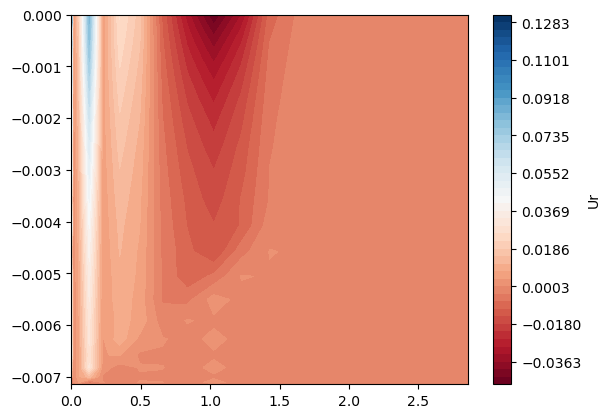

In [470]:
# Eigen_vector velocity:
velocity = eigvalvec[1]
level = np.linspace(velocity.min(), velocity.max())
plt.contourf(r, z, np.real(velocity), levels=level, cmap='RdBu')
# for i in range(len(u_index[0])):
    # plt.axvline(x=r[u_index[1][i]], color='blue', linestyle='--')

cbar = plt.colorbar()
cbar.set_label('Ur')

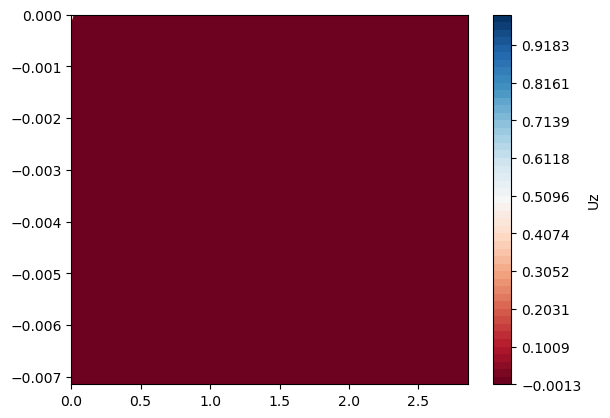

In [471]:
velocity1 = eigvalvec[2]
level = np.linspace(velocity1.min(), velocity1.max())
plt.contourf(r, z, np.real(velocity1), levels=level, cmap='RdBu')
cbar = plt.colorbar()
cbar.set_label('Uz')

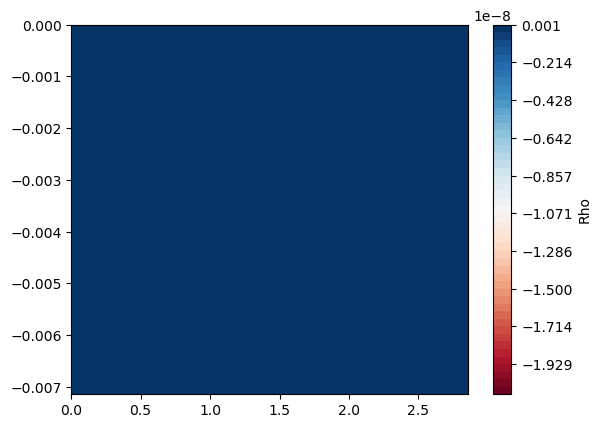

In [472]:
velocity2 = eigvalvec[3]
level = np.linspace(velocity2.min(), velocity2.max())
plt.contourf(r, z, np.real(velocity2), levels=level, cmap='RdBu')
cbar = plt.colorbar()
cbar.set_label('Rho')

(23, 23)


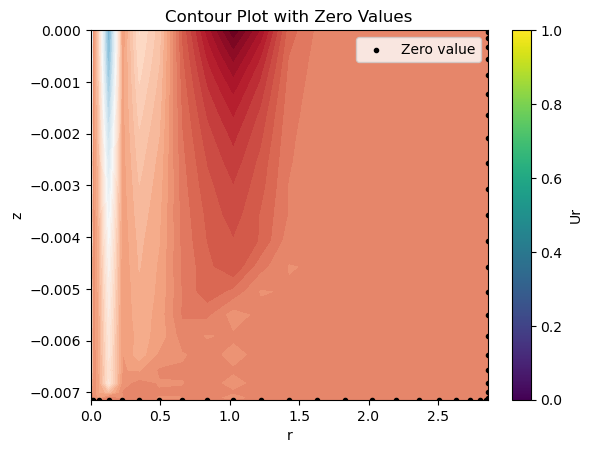

In [501]:
# Create a mask for zero values
# velocity = np.dot(diff_mat(N, M, Lr, Lz)[1],eigvalvec[2].flatten()).reshape(M+1, N+1)
velocity = eigvalvec[1]
zero_mask = np.isclose(velocity, 0.0)
print(velocity.shape)

# Plot contourf
level = np.linspace(velocity.min(), velocity.max())
plt.contourf(r, z, np.real(velocity), levels=level, cmap='RdBu')

# Plot zero values as points
plt.scatter(r[zero_mask], z[zero_mask], color='black', marker='.', label='Zero value')

# Add colorbar and labels
cbar = plt.colorbar()
cbar.set_label('Ur')
plt.xlabel('r')
plt.ylabel('z')
plt.title('Contour Plot with Zero Values')
# plt.xlim([-1, 21])

plt.legend()
plt.show()

In [474]:
def curl(u):
    u = u.flatten()
    dudr = np.dot(diff_mat(N, M, Lr, Lz)[0], u)
    dudz = np.dot(diff_mat(N, M, Lr, Lz)[1], u)
    curl_theta = dudz - dudr
    return dudr.reshape(M+1, N+1), dudz.reshape(M+1, N+1), curl_theta.reshape(M+1, N+1)

/tmp/ipykernel_153141/3113353165.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  D[k,j] = -(y[k])/(2 * (1 - y[k]**2))


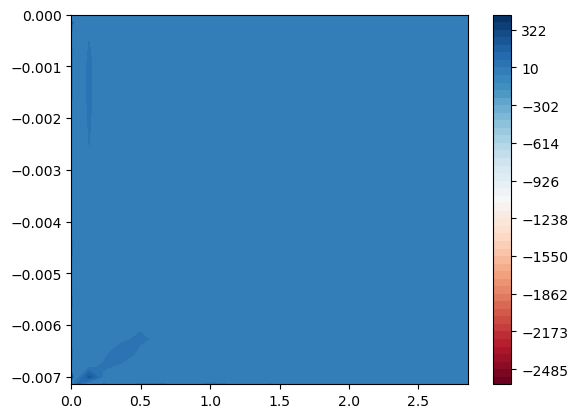

In [475]:
curlu =  curl(velocity)[1]
level = np.linspace(curlu.min(), curlu.max())

plt.contourf(r, z, curlu, levels = level, cmap='RdBu')
cbar = plt.colorbar()

In [476]:
# phi = np.linspace(0, 2*np.pi, 21)
# r, z = r_real(N, Lr), z_real(M,  Lz)
# x = r*np.cos(phi)
# y = r*np.sin(phi)
# z = z

# X, Y, Z = np.meshgrid(x, y, z)

# U = np.exp(-(X/2) ** 2)

# # Creating figure
# fig = plt.figure()
# ax = plt.axes(projection="3d")

# # Creating plot
# ax.scatter3D(X, Y, Z, c=U, alpha=0.7, marker='*')
# plt.show()

In [477]:
# # r-theta visualization
# theta = np.linspace(0, 2 * np.pi, 360)
# r = r_real(N,r_real(N, Lr))
# z = r_real(M,r_real(M, Lz))
# r1, z1 = np.meshgrid(r, z)
# r, theta = np.meshgrid(r, theta)

# radius_matrix, theta_matrix = np.meshgrid(r,theta)


In [478]:
# radius_matrix, theta_matrix = np.meshgrid(r,theta)
# X = radius_matrix * np.cos(theta_matrix)
# Y = radius_matrix * np.sin(theta_matrix)

In [479]:
# # import matplotlib.pyplot as plt
# ax = plt.subplot(111, polar=True)
# n=0
# # ax.contourf(theta, r , np.real(eigvalvec[3][0,:]*np.exp(1j*n*theta)))
# ax.contourf(theta, r , np.real(mean_flow(r1, z1)[1][0,:]) + 0 * theta)
# # ax.set_yticklabels([])
# # tick_positions = [0, np.pi/2, np.pi, 3*np.pi/2]
# # tick_labels = ['0/2π', 'π/2', 'π', '3π/2']
# # ax.set_xticks(tick_positions)
# # ax.set_xticklabels(tick_labels)
# # # cbar = fig.colorbar(im1, ax=axs, shrink=0.8)
# # # cbar.ax.set_title('max')
# # # cbar_ticks = np.linspace(eigvalvec[3][0, :].real.min(), eigvalvec[3][0, :].real.max(), 5)
# # # cbar.set_ticks(cbar_ticks)

# # plt.show()

In [480]:
# def generate_plot(m):
#     ax = plt.subplot(111, polar=True)
#     ax.contourf(theta, r, np.real(mean_flow(r1, z1)[2][m, :] * np.exp(1j * n * theta * 0)))
#     ax.set_yticklabels([])
#     tick_labels = [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$', r'$3\frac{\pi}{2}$']
#     plt.title(f"m = {m}")  # Add a title with the value of m
#     plt.savefig(f"/home/aiswarya/2nd_year/project_stability/codes/GIF/plot_m_{m}.png")  # Save the plot as an image file
#     plt.close()  # Close the plot to prevent it from displaying

# # Generate plots for each value of m
# for m in range(M+1):
#     generate_plot(m)

# terminal command to make gif // convert -delay 30 -loop 0 *.png GIF.gif


In [481]:
def fun(r, z):
    return -r**3 + 2*z**2
def fun1(r, z):
    return -3 * r**2
def fun2(r, z):
    return 4 * z


r, z = r_real(N, Lr), z_real(M,  Lz)
r, z = np.meshgrid(r, z)

der =diff_mat(N, M, Lr, Lz)[0]@fun(r,z).flatten()
d = der.reshape(M+1, N+1) 

/tmp/ipykernel_153141/3113353165.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  D[k,j] = -(y[k])/(2 * (1 - y[k]**2))


In [482]:
print(d)

[[ 3.55271368e-15 -6.34304359e-04 -1.00458318e-02 -4.99982220e-02
  -1.54288413e-01 -3.65254717e-01 -7.29312937e-01 -1.29190322e+00
  -2.09228331e+00 -3.15862114e+00 -4.50381941e+00 -6.12244898e+00
  -7.98908075e+00 -1.00581940e+01 -1.22657122e+01 -1.45320865e+01
  -1.67667187e+01 -1.88734076e+01 -2.07564157e+01 -2.23267001e+01
  -2.35078329e+01 -2.42411594e+01 -2.44897959e+01]
 [ 1.42108547e-14 -6.34304359e-04 -1.00458318e-02 -4.99982220e-02
  -1.54288413e-01 -3.65254717e-01 -7.29312937e-01 -1.29190322e+00
  -2.09228331e+00 -3.15862114e+00 -4.50381941e+00 -6.12244898e+00
  -7.98908075e+00 -1.00581940e+01 -1.22657122e+01 -1.45320865e+01
  -1.67667187e+01 -1.88734076e+01 -2.07564157e+01 -2.23267001e+01
  -2.35078329e+01 -2.42411594e+01 -2.44897959e+01]
 [ 1.42108547e-14 -6.34304359e-04 -1.00458318e-02 -4.99982220e-02
  -1.54288413e-01 -3.65254717e-01 -7.29312937e-01 -1.29190322e+00
  -2.09228331e+00 -3.15862114e+00 -4.50381941e+00 -6.12244898e+00
  -7.98908075e+00 -1.00581940e+01 -1.226

In [483]:
fun1(r, z)

array([[-0.00000000e+00, -6.34304359e-04, -1.00458318e-02,
        -4.99982220e-02, -1.54288413e-01, -3.65254717e-01,
        -7.29312937e-01, -1.29190322e+00, -2.09228331e+00,
        -3.15862114e+00, -4.50381941e+00, -6.12244898e+00,
        -7.98908075e+00, -1.00581940e+01, -1.22657122e+01,
        -1.45320865e+01, -1.67667187e+01, -1.88734076e+01,
        -2.07564157e+01, -2.23267001e+01, -2.35078329e+01,
        -2.42411594e+01, -2.44897959e+01],
       [-0.00000000e+00, -6.34304359e-04, -1.00458318e-02,
        -4.99982220e-02, -1.54288413e-01, -3.65254717e-01,
        -7.29312937e-01, -1.29190322e+00, -2.09228331e+00,
        -3.15862114e+00, -4.50381941e+00, -6.12244898e+00,
        -7.98908075e+00, -1.00581940e+01, -1.22657122e+01,
        -1.45320865e+01, -1.67667187e+01, -1.88734076e+01,
        -2.07564157e+01, -2.23267001e+01, -2.35078329e+01,
        -2.42411594e+01, -2.44897959e+01],
       [-0.00000000e+00, -6.34304359e-04, -1.00458318e-02,
        -4.99982220e-02, -1.5

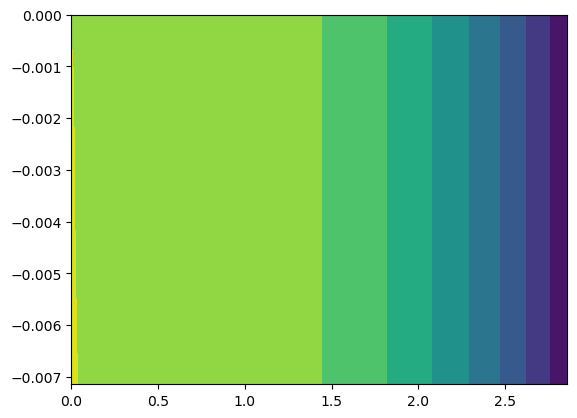

In [484]:
plt.contourf(r, z, fun(r,z))

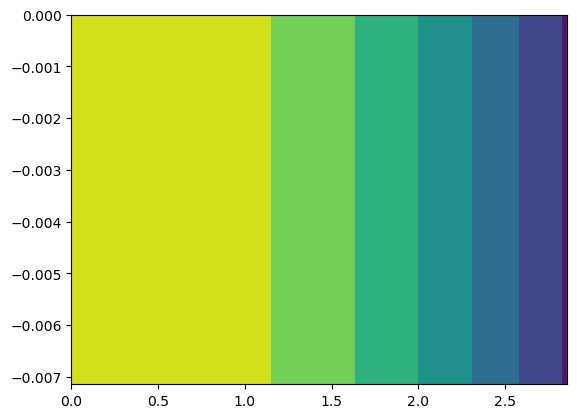

In [485]:
plt.contourf(r, z, fun1(r,z))

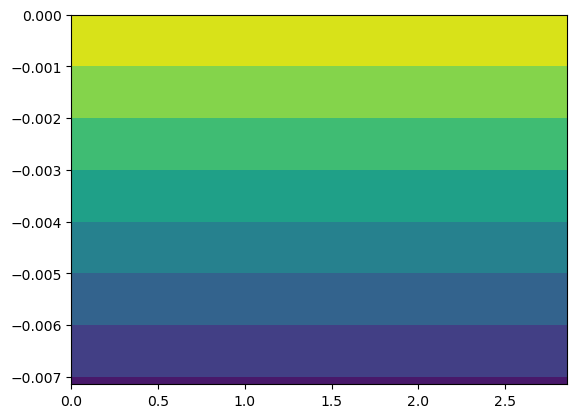

In [486]:
plt.contourf(r, z, fun2(r,z))

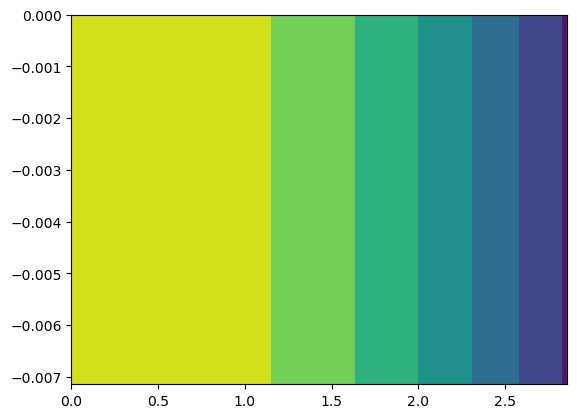

In [487]:
plt.contourf(r, z, d)

In [488]:
N = 5
print(np.dot(Cheb_der(N, x(N)),Cheb_der(N, x(N))))

[[ 41.6        -68.36067977  40.82755348 -23.63932023  17.57244652
   -8.        ]
 [ 21.2859127  -31.53312629  12.68328157  -3.69442719   2.21114562
   -0.9527864 ]
 [ -1.8472136    7.31671843 -10.06687371   5.78885438  -1.90557281
    0.7140873 ]
 [  0.7140873   -1.90557281   5.78885438 -10.06687371   7.31671843
   -1.8472136 ]
 [ -0.9527864    2.21114562  -3.69442719  12.68328157 -31.53312629
   21.2859127 ]
 [ -8.          17.57244652 -23.63932023  40.82755348 -68.36067977
   41.6       ]]


/tmp/ipykernel_153141/3113353165.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  D[k,j] = -(y[k])/(2 * (1 - y[k]**2))


In [489]:
data = np.load('/home/aiswarya/2nd_year/project_stability/cluster/210524_error.npz')
l2 = data['L2']
res = data['res']
l2

array([ 4.47503212+0.89115978j,  3.36993874+0.6257456j ,
       10.59323852+0.16687615j,  8.57166538-0.11496759j,
        7.24273899+0.19908878j, -1.10579771-0.04077506j,
        3.35456249-0.14382315j])

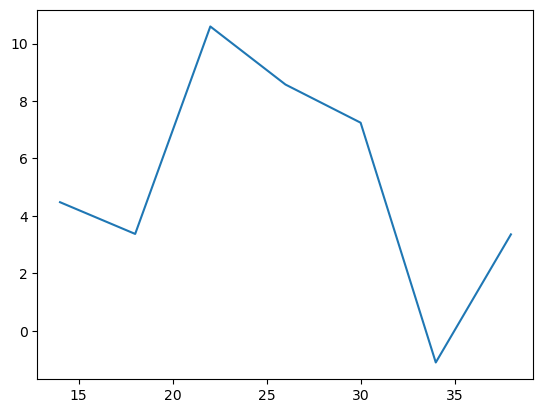

In [490]:
plt.plot(res, np.real(l2))


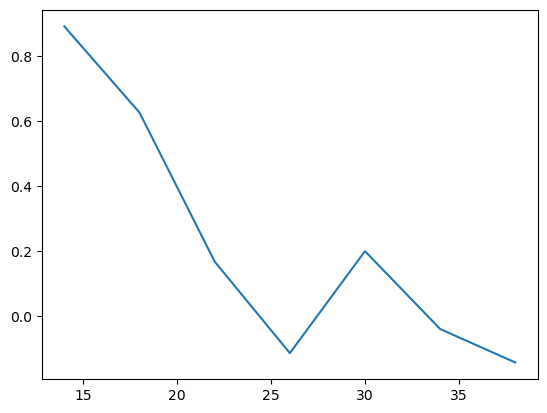

In [491]:
plt.plot(res, np.imag(l2))

In [492]:
fun = np.exp(x(N))
fun

array([2.71828183, 2.24569937, 1.36208552, 0.73416829, 0.44529558,
       0.36787944])

In [493]:
print(Cheb_der(N, x(N)) @ np.exp(x(N)))

[2.71724145 2.24620422 1.36161732 0.73459718 0.44489444 0.36866217]


/tmp/ipykernel_153141/3113353165.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  D[k,j] = -(y[k])/(2 * (1 - y[k]**2))


In [494]:
D = np.zeros((5, 5))
D

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [495]:
D[4, 4] = 4
D

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 4.]])

In [496]:
Cheb_der(4, x(4))

/tmp/ipykernel_153141/3113353165.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  D[k,j] = -(y[k])/(2 * (1 - y[k]**2))


array([[ 5.50000000e+00, -6.82842712e+00,  2.00000000e+00,
        -1.17157288e+00,  5.00000000e-01],
       [ 1.70710678e+00, -7.07106781e-01, -1.41421356e+00,
         7.07106781e-01, -2.92893219e-01],
       [-5.00000000e-01,  1.41421356e+00, -3.06161700e-17,
        -1.41421356e+00,  5.00000000e-01],
       [ 2.92893219e-01, -7.07106781e-01,  1.41421356e+00,
         7.07106781e-01, -1.70710678e+00],
       [-5.00000000e-01,  1.17157288e+00, -2.00000000e+00,
         6.82842712e+00, -5.50000000e+00]])